In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import numpy as np
import joblib
from tqdm import tqdm
import pickle

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [6]:
dataset_csv = pd.read_csv("/content/Suicidal_tweet_dataset_advanced_corrected (2).csv")
dataset = pd.DataFrame(dataset_csv)
dataset.head()

,Unnamed: 0,text,class,corrected_text
0,74414,dont know7 month self harm free urg get strong...,suicide,don't know7 month self harm free URG get stron...
1,149516,start becom rich start compani becom 16 afford...,non-suicide,Start become rich start company become 16 affo...
2,12484,poem haiku umegamedev hi hello hello stop fuck...,non-suicide,Poem haiku megameter hi hello stop fuck say he...
3,14043,ive honestli got idea anymoreit feel everyon f...,suicide,Ive honestly got idea anymore it feel everyone...
4,30673,ever cri like think unfair life cri cant cri e...,non-suicide,Ever cry like think unfair life cry can't cry ...


In [7]:
dataset.shape

(10002, 4)

In [8]:
# check for null values
dataset.isnull().sum()

,0
Unnamed: 0,0
text,2
class,2
corrected_text,3


In [9]:

dataset.dropna(subset=['text'], inplace = True)
dataset.dropna(subset=['corrected_text'], inplace = True)
dataset['text'] = dataset['corrected_text']

In [10]:
#shape after removal of null values
print(dataset.shape)

(9998, 4)


In [11]:
dataset.head()

,Unnamed: 0,text,class,corrected_text
0,74414,don't know7 month self harm free URG get stron...,suicide,don't know7 month self harm free URG get stron...
1,149516,Start become rich start company become 16 affo...,non-suicide,Start become rich start company become 16 affo...
2,12484,Poem haiku megameter hi hello stop fuck say he...,non-suicide,Poem haiku megameter hi hello stop fuck say he...
3,14043,Ive honestly got idea anymore it feel everyone...,suicide,Ive honestly got idea anymore it feel everyone...
4,30673,Ever cry like think unfair life cry can't cry ...,non-suicide,Ever cry like think unfair life cry can't cry ...


In [12]:
print(dataset['corrected_text'].shape)
print(dataset['text'].shape)

(9998,)
(9998,)


In [13]:
# Recheck for Null Values
dataset.isnull().sum()


,0
Unnamed: 0,0
text,0
class,0
corrected_text,0


In [14]:
import plotly.express as plx

class_counts = dataset['class'].value_counts().reset_index()
class_counts.columns = ['class', 'count']

plx.bar(class_counts, x='class', y='count', color='class', title="Class Distribution")


In [15]:
# Mapping of Label
dataset.loc[dataset['class'] == 'suicide', 'class',] = 0
dataset.loc[dataset['class'] == 'non-suicide', 'class',] = 1
dataset['class'].unique()

array([0, 1], dtype=object)

In [16]:
# stemming and cleaing of text data
port_stem = PorterStemmer()

def stemming(content):
    content = content.lower()
    stemmend_content = re.sub('[^a-zA-z]',' ',content)
    stemmend_content = re.sub(r'[^\w\s]', '', stemmend_content)
    stemmend_content = re.sub(r"\n", '', stemmend_content)
    stemmend_content = re.sub(r'\d', '', stemmend_content)
    stemmend_content = re.sub(r'\[.*?\]', '', stemmend_content)
    stemmend_content = re.sub(r'https?://\S+|www\.\S+', '', stemmend_content)
    stemmend_content = re.sub(r'<.*?>+', '', stemmend_content)
    stemmend_content = re.sub(r'\w*\d\w*', '', stemmend_content)
    stemmend_content = stemmend_content.lower()
    stemmend_content = stemmend_content.split()
    stemmend_content = [port_stem.stem(word) for word in stemmend_content if not word in stopwords.words('english')]
    stemmend_content = ' '.join(stemmend_content)
    return stemmend_content

In [17]:
# stemming of text data
dataset['stemmend_content'] = dataset['text'].apply(stemming)

In [19]:
# suicide Keywords
# Final
suicide_keywords = ["suicide", "suicidal", "kill myself", "want to die", "end my life", "death", "die", "dying", "hopeless", "depressed", "depression", "despair", "pain","parent",'drug',
    "suffering", "worthless", "no point", "can’t go on", "tired of living", "no reason to live", "give up", "want to end it", "feel alone", "lonely", "isolated", "empty","need someone",
    "numb", "self-harm", "cut", "overdose", "pills", "hang", "jump", "cliff", "gun",  "rope", "blade", "blood", "void", "dark", "black cloud", "no future", "can’t see a way out",'cry',
    "life is pointless", "want peace", "escape", "burden", "failure", "useless","not good enough", "hate myself",  "self-hatred", "guilt", "shame", "regret", "no hope", "lost",'sick',
    "broken", "can’t cope", "overwhelmed", "anxiety", "fear of living", "fear of death", "fear of failure",  "no one cares", "no one understands",  "no help",  "can’t get help",'kill',
    "therapist won’t help", "medication doesn’t work", "mental breakdown", "suicidal thoughts", "plan to die""method", "helium", "plastic bag", "drain cleaner", "fentanyl","i'm tired",
    "carbon monoxide", "poison","slit wrists", "crash car", "jump off bridge",  "no purpose", "life sucks", "misery", "agony", "torment", "trapped","stuck",  "can’t breathe","struggle",
    "chest hurts", "cry all the time", "scream inside","want to disappear", "better off dead", "world would be better without me", "family would be better off", "friends don’t care",
    "lost everyone", "abandoned", "betrayal", "trauma", "abuse", "physical pain", "emotional pain", "chronic pain", "can’t sleep", "sleepless nights", "nightmares", "dark thoughts",
    "violent thoughts", "obsession with death", "countdown to death", "last day", "final goodbye", "suicide note", "no one to talk to", "no support", "rejected", "unloved", 'thank','upset',
    "unlovable", "invisible", "ghost", "hollow", "soul crushed", "heart heavy", "stone in chest", "can’t feel joy", "can’t feel love", "life is a prison", "want to sleep forever", "broke",
    "never wake up", "eternal rest", "peace in death", "fear of waking up", "brain damage", "fail at suicide", "scared to fail", "scared to succeed", "guilt about family",'cant make friends',
    "hurt loved ones", "selfish to die", "can’t hurt others", "responsibility to live", "obligation to stay", "no escape", "endless struggle", "rock bottom", "can’t climb out",'feel trap',
    "bad day","im afraid","die","trigger","lost job", "relationship","cheat","kill myself","feel helpless", "can't take anymore", "i drank poison","depart this world" ,"fuck trippiersuicide",
    "utterly alone" ,"want fuck die","still hope gone","commit suicide day ago","don't know I'll kill in future","Antidepressants","Clinics", "Disappointment","cut","Low self-esteem",
    "hopeless", "despair" , "dysphoria", "helpless" , "lost","giving up","leave","hurt", "pain", "goodbye","Intrusive thoughts","Autopilot","Family issues","Anti-anxiety medication",
    "no hope","i'm a forgetting person", "Self murder" , "self destruction" , "chance - medley" , "Hari-kari", "homicide" , "man slaughter" , "foul play" , "slaying","Isolation","Purgatory",
    "Emotional numbness","life suck","brief depress","held little power" , "disconnected","lowest","distraught","drastic measure","unalive","unaliving","unalived","sewerslide","ending",
    "ghost","KMS","KYS","Menty B","Crash out","burnout","fade away","check out","Tap out","vanish","over it","endgame","exit stage left","no returns","don't want to live now", "drug overdosed"
    "spiral downward", "end the pain", "end it all", "meaningless","i can’t take it", "everything hurts", "take my life", "don’t want to live", "jump off", "tired of life", "done with life",
    "over it", "bleed out","hang myself", "overdose myself", "knife", "drown", "suffocate", "slit", "stab myself", "i wish i were dead", "nobody cares", "stress", "desperation", "anguish",
    "shattered", "falling apart", "nothing left", "want out", "too much", "breaking point", "hollow inside", "dead inside", "no strength", "exhausted", "crying", "sobbing", "panic","lone",
    "collapsing", "numbness", "bleeding", "razor", "shoot myself", "shoot", "gas", "toxic", "fatal", "goodbye", "last breath", "final moments", "done fighting", "let me go", "release me",
    "no way forward", "all over", "over", "finished", "wasting away", "wasting", "beyond help", "irreparable", "devastated", "therapy", "heroin", "overdose", "treat", "deserted", "hopeless",
    "embarrased", "embarass", "embarassing", "cheat", "cheated on", "ruin", "ruined", "dead", "coffin", "low life", "tragic", "overly sad", "past trauma", "pull trigger", "toxic relation",
    "suicide","beg","pathed","escape","fuck","alcohol"," self harm","empathyremors","selfconsci","relief","repress","TRI","diagnose","shotgun","disappear","antipsychotic","mind","guilt",
    "die","insult","illegitimate","shithead","stupidly","Ruin life", "scare","exhaust","goodbye","therapist","cry","dead hit", "dead","fear","hang","anguish","shoot","horrible","Fuckim",
    "jump","balcony","scream","silent","coward","scar","hate", "Gun","failure","depress","relationship","debt","girlfriend","anxious",  "psychiatrist","distraught","conscious","inferior",
    "dumb","physic","diminish", "overwhelm","angry","schizophrenia","miser","suicid","molest","harm","frustrate","divorce","fuck", "end","trauma","self-hate","jerk","lost","pointless","worthless",
    "struggle","rest","rest", "annoy","luckless","chance","peace","knife","bullshit","bleed","Jealousim","Nan", "schizophrenia","unhappy","ridicule","mistake","druggy","dumbass","commit",
    "escape","throwaway","pressure","hope","sync","careless","Subreddit","survive","assault", "painkillers","torture","burden","miser","serious","evil","distress","antidepress","Reddit",
    "suicide", "kill myself", "killing myself", "self harm", "depressed", "depression", "hopeless", "worthless", "give up", "end it all", "tired of life", "want to die", "can't go on",
    "no reason to live", "pain", "suffering", "die", "dying", "cut myself", "cutting", "hurt myself", "end my life", "hate myself", "life is pointless", "ending it", "I'm done", 'girlfriend',
    "take my life", "why live", "jump off", "pills", "overdose", "slit", "goodbye world", "empty", "lost", "alone", "lonely", "no one cares",  "anxiety", "crying", "hurting", "miserable",
    "despair", "overwhelmed", "helpless", "burden", "fail", "failure", "worthless", "can't sleep", "no hope", "trapped", "done", "numb", "exhausted", "can't take it", "can't handle",
    "hate life", "i'm not okay", "i give up", "nothing matters", "it's too much", "can't breathe", "sick of this", "hate everything", "i'm broken", "falling apart", "wish i could disappear",
    "don’t want to wake up", "no one understands", "not enough", "i failed", "everyone hates me", "suffocating", "wish I was gone", "just want peace", "can't keep going", "it hurts",
    "everything hurts", "so tired", "so alone", "can’t take the pain", "feel so lost", "can’t escape", "feel worthless","feel like a burden", "emptiness", "failure", "numb", "exhaustion",
    "despair", "overwhelmed", "broken", "worthlessness", "regret", "self-loathing", "void", "loneliness", "lost all hope", "no reason to continue", "everything feels pointless",'hard put'
    "wish I could freeze time", "life feels empty", "tired of pretending", "can’t stop crying", "I’m broken inside", "nothing makes sense anymore", "don’t want to wake up tomorrow",
    "everything hurts too much", "want to escape this suffering", "feel like I’m drowning", "want to disappear forever","hopelessness", "invisible", "broken", "anxious","I'm tired",
    "wish I was never born", "don’t see a way out", "I’m exhausted from life", "can’t take the pain anymore", "cant afford", "don't real", "goodbye", "sacrifice", "leave", "reach end",
    "Help", "drunk", "meth","methapthamine","jail","I'm done","sad feel","hurt","physic","hell", "problem","burn","burn alive","surgery","paralysis","unable","suffer","assualt","pill",
    "parental","horrible","heart break","blame","dysphoria","top floor","jump","one talk","nobody", "threat", "lost", "void","don't want", "fail","bull","weak","attempt","depersonalization",
    "unbearable", "I'm worst", "I'm burdern", "useless", "unless", "want talk", "sexual assualt", "dead","hang", "worry", "worried", "sorry", 'mommy', "daddy", "weird", "wrong", "ill",
    "freak", "creepy", "destroy", "wasted", "not left", "overdose", "divorce", "creep", "bastard", "trouble", "apology", "harass", "self harm", "shut", "restless", "lost mind", 'self cut',
    "lonely", "disappoint","disappointment","Im sorry", "asshol", "disappear", "ruin", "ruined", "hate", "disappear","loser", "evil", "coronavirus","hate", "Hate", "I'm exhaust",
    "family probelm", "Im tire", "insecure","discomfort","unfair","don't want deal","homeless","lost hope", "garbage", "burden", "Im useless", "I'm killer", "I'm far gone", "suicide feelings",
    "end life", "don't want","anymore","disgust", "pointless", "quit", "sturggle", "worry","homesick", "End life",  "Cut", "shit", "ill jump", "can't bare", "exit", "note",  "I've never",
    "hate", "hate love","hate people", "stuck", "i'm sick", "I'm scare", "wish talk somebody", "scare", "anymore","hotline", "fail", "feel guilty", "last time", "break", "leaving this world",
    "anymore", "breakdowm", "isn't enough", "Cant take anymore", "I'm done", "I'm narcissist", "falut", "faluty", "panic attack", 'feel verbal', 'social inept', 'drug alcohol', 'alcohol',
    "I am scare", "nobody eve gave shit", "getting worse", " nobody help", "nobody care", "I am gonna be adult soon", 'wish I was 13 only', 'worthless', "can't do anything", "can't contribute",
    "don't want to give response", 'need attention', 'need care', 'dumb', 'psycho', 'panic attack', 'cant dress right way', 'cant do homework', "can't express", 'cant talk', 'cant fall in love',
    'dont want describe', 'breath hold', 'kill', 'random', 'yelling', 'finish', 'freak struggle', 'total thrash', 'self harm', "don't wanna exist", 'people want kill', 'freak', "don't like hear",
    'class drop', 'pretend', "didn't tell parents", 'drug', 'addiction', 'money', 'cheat', 'violent', 'hate', 'scream', 'escape', 'horrible', 'ignore', 'desire', 'dont care', 'anxious',
    'cant meet new people', 'drop', 'TRI', 'i am stuck', 'no progress', 'depress', 'endless cycle', 'i am away',  'therapist ','i am bad explain people', "don't want to exist", 'go wrong',
    'i dont care', 'lonely', 'hang', 'mental health', 'discord server', 'stress', 'burden', 'stupid' , 'hotline', 'rude', 'family problem', 'aggress', 'hung', 'offcut', 'really upset',
    'uncertainity' , 'achieve goal', 'still alive', 'dont want live', 'shut', 'dont feel', 'fear', 'detach reality', 'lust', 'need advice', 'please', 'hard explain', 'disgust', 'i am sick',
    "don't fit", 'ask leave', 'feel like broken tool', 'nobody want around', 'life meaningless', 'danger', 'failure', 'refuse', ' biggest regret', 'fuck', 'suck', "don't like schol",
    'pain', 'breakdown', "didn't want to attend school", 'suicide', 'fail', "can't afford", 'failure', 'kill myself', 'house arrest', 'reckless drive', 'crash', 'self gun', 'Help please',
    'speechless', "couldn't even bare thought", 'please help',
  ]

dataset['keyword_flag'] = dataset['stemmend_content'].apply(lambda x: int(any(kw in x for kw in suicide_keywords)))

In [20]:
# Custom transformer to extract 'keyword_flag'
class KeywordFlagExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, keyword_flags):
        self.keyword_flags = keyword_flags

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.keyword_flags.reshape(-1, 1)

In [21]:
# Prepare vectorizer
vectorizer = TfidfVectorizer(
    max_features=3900,
    min_df=12,
    max_df=0.99,
    ngram_range=(1, 3)
)

X_tfidf = vectorizer.fit_transform(dataset['stemmend_content'])
keyword_flags = dataset['keyword_flag'].values

In [22]:
X_combined = hstack([X_tfidf, keyword_flags.reshape(-1, 1)])
Y_label = dataset['class'].astype(int)

In [23]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X_combined, Y_label, test_size=0.2, random_state=42)


In [24]:
# Train model
lr = LogisticRegression(max_iter=1000)
param_grid = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'C': [0.8, 1, 1.2, 1.5, 2],
}

grid_search = GridSearchCV(lr, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Save both vectorizer and model
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(grid_search.best_estimator_, 'model.pkl')


['model.pkl']

In [25]:
# Best Parameters
print(grid_search.best_params_)

{'C': 2, 'penalty': 'l2', 'solver': 'saga'}


In [26]:
# taking best model
model = grid_search.best_estimator_

In [27]:
# check overfitting and training accuracy
prediction_train = model.predict(x_train)
score_train = accuracy_score(prediction_train, y_train)
print(score_train)

0.9534883720930233


In [28]:
# Prediction on test
prediction_test = model.predict(x_test)
score_test = accuracy_score(prediction_test, y_test)
print(score_test)

0.9165


Actual Number of classes in train and test data

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import plotly.express as px
# Best model
best_lr = grid_search.best_estimator_

# Predictions
# y_train_pred = best_lr.predict(x_train)
# y_test_pred = best_lr.predict(x_test)

# Count predictions
train_pred_counts = pd.Series(y_train).value_counts()
test_pred_counts = pd.Series(y_test).value_counts()

# Convert to DataFrames for Plotly
df_train_pred = pd.DataFrame({
    'Task': ['Suicidal', 'Non-Suicidal'],
    'Start': [0, 0],
    'Finish': [train_pred_counts.get(1, 0), train_pred_counts.get(0, 0)],
    'Dataset': 'Train Predictions'
})

df_test_pred = pd.DataFrame({
    'Task': ['Suicidal', 'Non-Suicidal'],
    'Start': [0, 0],
    'Finish': [test_pred_counts.get(1, 0), test_pred_counts.get(0, 0)],
    'Dataset': 'Test Predictions'
})

# Combine DataFrames
df_lr_gantt = pd.concat([df_train_pred, df_test_pred], ignore_index=True)

# Plot
fig = px.bar(df_lr_gantt,
             x="Finish",
             y="Dataset",
             color="Task",
             orientation='h',
             title="Logistic Regression Predictions: Suicidal vs Non-Suicidal",
             labels={'Finish': 'Predicted Count'},
             color_discrete_map={'Suicidal': '#00dddf', 'Non-Suicidal': '#000fbb'})

fig.update_layout(barmode='stack')
fig.show()


Predicted number of class in train and test data

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import plotly.express as px
# Best model
best_lr = grid_search.best_estimator_

# Predictions
y_train_pred = best_lr.predict(x_train)
y_test_pred = best_lr.predict(x_test)

# Count predictions
train_pred_counts = pd.Series(y_train_pred).value_counts()
test_pred_counts = pd.Series(y_test_pred).value_counts()

# Convert to DataFrames for Plotly
df_train_pred = pd.DataFrame({
    'Task': ['Suicidal', 'Non-Suicidal'],
    'Start': [0, 0],
    'Finish': [train_pred_counts.get(1, 0), train_pred_counts.get(0, 0)],
    'Dataset': 'Train Predictions'
})

df_test_pred = pd.DataFrame({
    'Task': ['Suicidal', 'Non-Suicidal'],
    'Start': [0, 0],
    'Finish': [test_pred_counts.get(1, 0), test_pred_counts.get(0, 0)],
    'Dataset': 'Test Predictions'
})

# Combine DataFrames
df_lr_gantt = pd.concat([df_train_pred, df_test_pred], ignore_index=True)

# Plot
fig = px.bar(df_lr_gantt,
             x="Finish",
             y="Dataset",
             color="Task",
             orientation='h',
             title="Logistic Regression Predictions: Suicidal vs Non-Suicidal",
             labels={'Finish': 'Predicted Count'},
             color_discrete_map={'Suicidal': '#00dddf', 'Non-Suicidal': '#000fbb'})

fig.update_layout(barmode='stack')
fig.show()


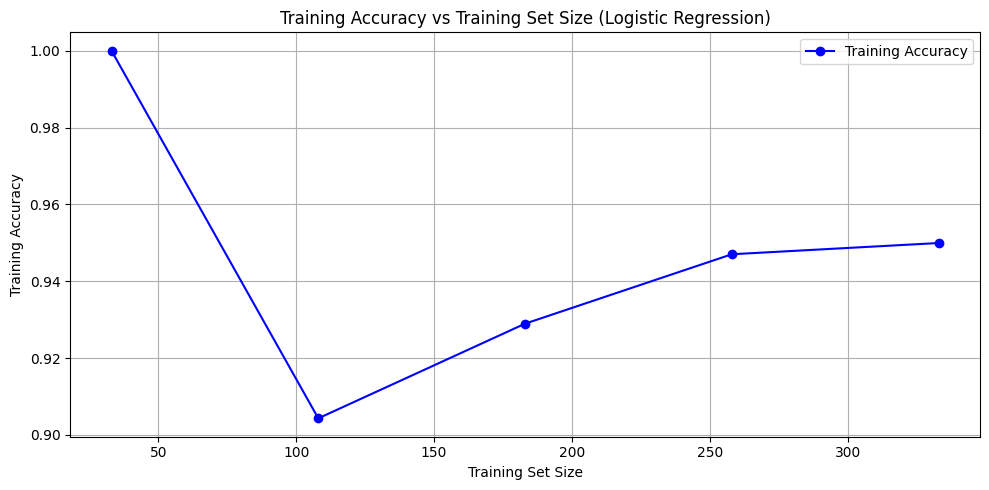

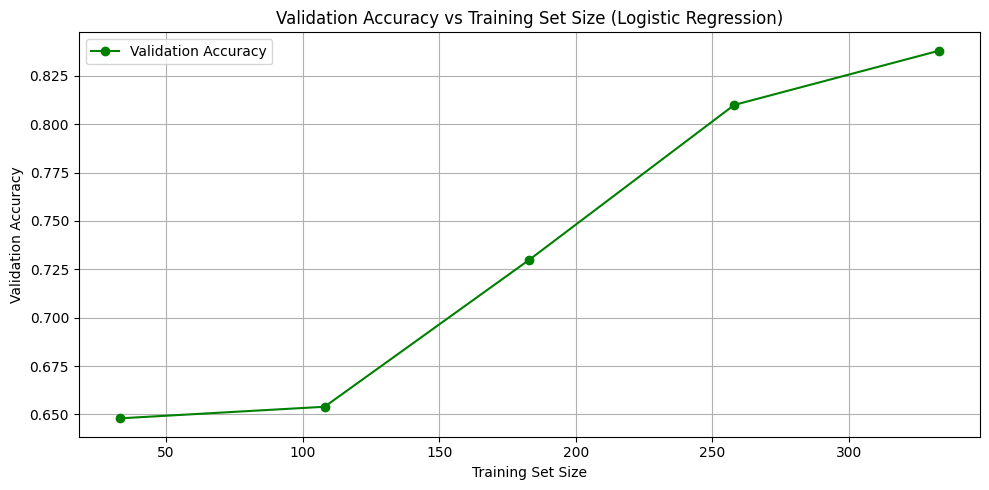

In [31]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model


# Optional: use a subset of data for faster execution
X_sample = x_train[:500]
y_sample = y_train[:500]

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    lr,
    X_sample,
    y_sample,
    cv=3,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Calculate mean scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot 1: Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_scores_mean, color='blue', marker='o', label='Training Accuracy')
plt.title('Training Accuracy vs Training Set Size (Logistic Regression)')
plt.xlabel('Training Set Size')
plt.ylabel('Training Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, test_scores_mean, color='green', marker='o', label='Validation Accuracy')
plt.title('Validation Accuracy vs Training Set Size (Logistic Regression)')
plt.xlabel('Training Set Size')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


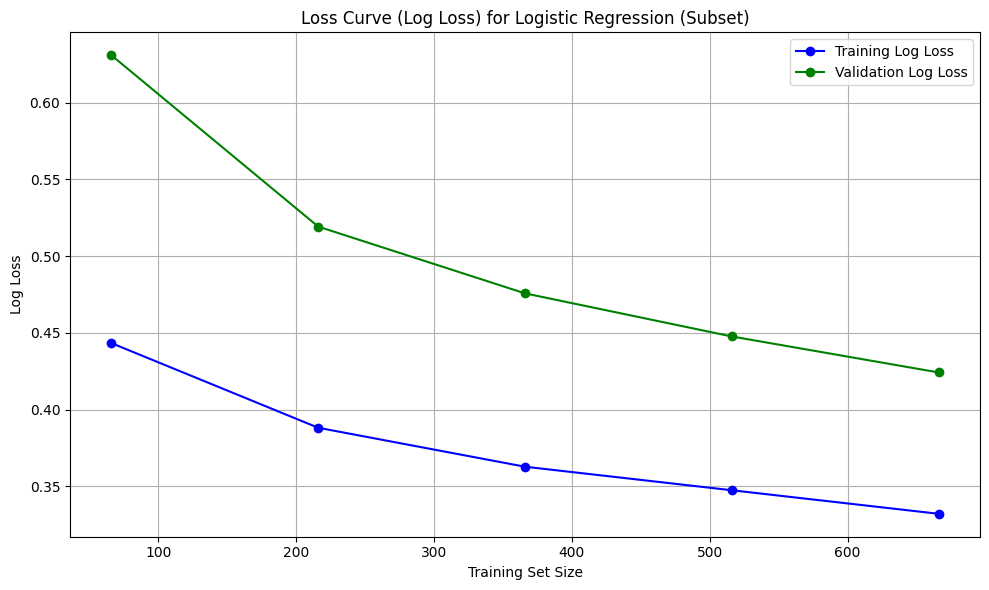

In [32]:

# Use a subset of training data
X_small = x_train[:1000]
y_small = y_train[:1000]

# Learning curve for Log Loss
train_sizes, train_scores, test_scores = learning_curve(
    lr,
    X_small,
    y_small,
    cv=3,
    scoring='neg_log_loss',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Convert to positive log loss
train_loss = -np.mean(train_scores, axis=1)
test_loss = -np.mean(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_loss, label='Training Log Loss', marker='o', color='blue')
plt.plot(train_sizes, test_loss, label='Validation Log Loss', marker='o', color='green')
plt.title('Loss Curve (Log Loss) for Logistic Regression (Subset)')
plt.xlabel('Training Set Size')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
import joblib

joblib.dump(model, '/content/sample_data/model.pkl')
joblib.dump(vectorizer, '/content/sample_data/vectorizer.pkl')

['/content/sample_data/vectorizer.pkl']